In [1]:
from omegaconf import OmegaConf
from titok import TiTok
import torch
from PIL import Image
import numpy as np

attention mode is flash


D:\pyproject\awesome_tokenizer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\pyproject\awesome_tokenizer\titok_tokenizer\modules\quantizer.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
D:\pyproject\awesome_tokenizer\titok_tokenizer\modules\quantizer.py:136: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
D:\pyproject\awesome_tokenizer\titok_tokenizer\modules\quantizer.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
D:\pyproject\awesome_tokenizer\titok_tokenizer\modules\quantizer.py:161:

In [2]:
config_path = "configs/titok_b64.yaml"
config = OmegaConf.load(config_path)

In [3]:
config

{'experiment': {'tokenizer_checkpoint': 'tokenizer_titok_b64.bin', 'generator_checkpoint': 'generator_titok_b64.bin', 'output_dir': 'titok_b_64'}, 'model': {'vq_model': {'codebook_size': 4096, 'token_size': 12, 'use_l2_norm': True, 'commitment_cost': 0.25, 'vit_enc_model_size': 'base', 'vit_dec_model_size': 'base', 'vit_enc_patch_size': 16, 'vit_dec_patch_size': 16, 'num_latent_tokens': 64, 'finetune_decoder': True}, 'generator': {'model_type': 'ViT', 'hidden_size': 768, 'num_hidden_layers': 24, 'num_attention_heads': 16, 'intermediate_size': 3072, 'dropout': 0.1, 'attn_drop': 0.1, 'num_steps': 8, 'class_label_dropout': 0.1, 'image_seq_len': '${model.vq_model.num_latent_tokens}', 'condition_num_classes': 1000, 'randomize_temperature': 11.0, 'guidance_scale': 3.0, 'guidance_decay': 'linear'}}, 'dataset': {'preprocessing': {'crop_size': 256}}}

In [4]:
titok_tokenizer = TiTok(config)
state_dict = torch.load("./checkpoints/tokenizer_titok_b64.bin", map_location="cpu")
titok_tokenizer.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [5]:
image = Image.open("./cat.jpg").convert("RGB")
image = image.resize((256, 256), Image.LANCZOS)
image = np.array(image).astype(np.float32) / 255.0
image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
image.shape

torch.Size([1, 3, 256, 256])

In [6]:
titok_tokenizer.eval()

TiTok(
  (encoder): TiTokEncoder(
    (patch_embed): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (conv_out): Conv2d(768, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): TiTokDecoder(
    (decoder_embed): Linear(in_features=12, out_features=7

In [7]:
encoded_tokens = titok_tokenizer.encode(image)[1]["min_encoding_indices"]
encoded_tokens

tensor([[[1109, 1579, 1103,  458, 1743, 2109, 3899, 1576, 1542,  737, 2575,
           308, 2344,  937, 3714,   87,  154,  568, 4034, 3264,  842, 1222,
          2428,  793,  774, 1759, 2451, 3796,  871, 1805, 3432, 1491, 3746,
           560, 4074, 2432, 3136, 3621, 1402, 3064, 2998,  151,  150, 1051,
          4007, 3101, 2392, 3259, 3967, 3074, 4002,   65, 3385, 3839,  852,
          1173, 3157, 3149, 3997,  380,  743,  465, 3333,   57]]])

In [8]:
reconstructed_image = titok_tokenizer.decode_tokens(encoded_tokens)
reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
reconstructed_image = Image.fromarray(reconstructed_image)

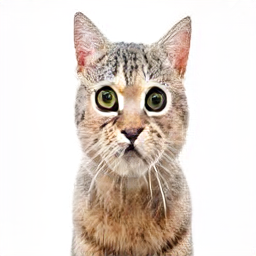

In [9]:
reconstructed_image